In [1]:
import itertools
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import requests

from fred import *

In [2]:
DATA_FOLDER = "data"

# What are we looking for?

Housing real estate is a market driven by several factors, including supply and demand. High supply and low demand drive market prices lower. Conversely, low supply and high demand drive market prices higher.

Home ownership is expensive: saving enough money for a down payment on a mortgage, paying mortgage debt, maintenance costs, property tax, etc. **Demand on the housing real estate market is driven by job abundance and quality**. The following attributes have a positive impact on home prices, or are positively correlated with home prices:
* positive job growth
* low unemployment rates
* high job diversity, where many industries make up the job market
* number of jobs in high growth industries (technology, healthcare, personal services, construction, etc)

# Employment data

## Unemployment rate

### Download data

In [3]:
base_url = "https://www.bls.gov/lau/laucnty{}.xlsx"

In [4]:
for year in range(1990, 2021):
    response = requests.get(base_url.format(str(year)[-2:]))
    with open(os.path.join(DATA_FOLDER, "unemployment", "laucnty{}.xlsx".format(str(year)[-2:])), "wb") as f:
        f.write(response.content)

### Processing

In [5]:
lau_data_types = {
    "laus_code": str,
    "state_fips": str,
    "county_fips": str,
    "county_state_name": str,
    "year": int,
    "empty": str,
    "labor_force": "Int32",
    "employed": "Int32",
    "unemployed_level": "Int32",
    "unemployed_rate": float,
}

In [6]:
df = pd.read_excel(
    os.path.join(DATA_FOLDER, "unemployment", "laucnty20.xlsx"),
    skiprows=5,
    skipfooter=3,
    names=lau_data_types.keys(),
    dtype=lau_data_types,
    na_values="N.A.",
    thousands=","
).drop(columns="empty")

In [7]:
df.head()

,laus_code,state_fips,county_fips,county_state_name,year,labor_force,employed,unemployed_level,unemployed_rate
0,CN0100100000000,01,001,"Autauga County, AL",2020,25838,24576,1262,4.9
1,CN0100300000000,01,003,"Baldwin County, AL",2020,96763,91338,5425,5.6
2,CN0100500000000,01,005,"Barbour County, AL",2020,8587,7982,605,7.0
3,CN0100700000000,01,007,"Bibb County, AL",2020,8640,8067,573,6.6
4,CN0100900000000,01,009,"Blount County, AL",2020,24661,23653,1008,4.1


In [8]:
unemp_df = pd.DataFrame(columns=["year", "country_unemployed_rate", "michigan_unemployed_rate", "ingham_unemployed_rate"])

for year in range(1990, 2021):
    df = pd.read_excel(
        os.path.join(DATA_FOLDER, "unemployment", "laucnty{}.xlsx".format(str(year)[-2:])),
        skiprows=5,
        skipfooter=3,
        names=lau_data_types.keys(),
        dtype=lau_data_types,
        na_values="N.A.",
        thousands=","
    ).drop(columns="empty")
    df_mi = df[df["state_fips"]=="26"]
    df_ingham = df[df["county_state_name"]=="Ingham County, MI"]
    unemp_df = unemp_df.append({
        "year": year,
        "country_unemployed_rate": df["unemployed_level"].sum() / df["labor_force"].sum() * 100,
        "michigan_unemployed_rate": df_mi["unemployed_level"].sum() / df_mi["labor_force"].sum() * 100,
        "ingham_unemployed_rate": df_ingham["unemployed_level"].sum() / df_ingham["labor_force"].sum() * 100,
    }, ignore_index=True)

In [9]:
unemp_df.tail()

,year,country_unemployed_rate,michigan_unemployed_rate,ingham_unemployed_rate
26,2016.0,4.917130,4.984732,4.329045
27,2017.0,4.399142,4.589518,4.255389
28,2018.0,3.930660,4.165347,3.647673
29,2019.0,3.700111,4.070508,3.442873
30,2020.0,8.052875,9.876656,7.453729


### Analysis

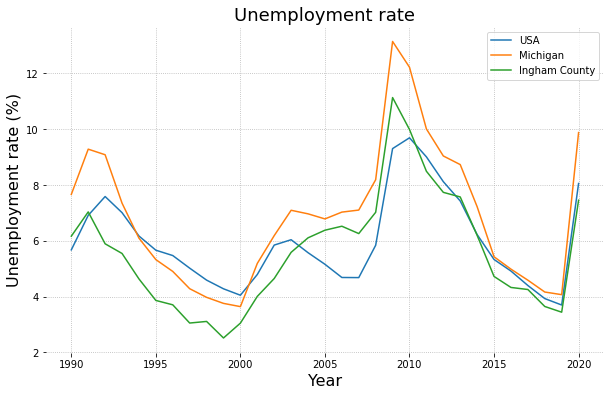

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(unemp_df["year"], unemp_df["country_unemployed_rate"], label="USA")
ax.plot(unemp_df["year"], unemp_df["michigan_unemployed_rate"], label="Michigan")
ax.plot(unemp_df["year"], unemp_df["ingham_unemployed_rate"], label="Ingham County")
ax.set_title("Unemployment rate", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Unemployment rate (%)", fontsize=16)
plt.legend()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":");

## Economic growth

In [11]:
dtypes = {"date": "date", "value": "float"}

In [12]:
ingham_gdp = parse_fred(download_fred("GDPALL26065"), dtypes=dtypes)
michigan_gdp = parse_fred(download_fred("MINGSP"), dtypes=dtypes)
us_gdp = parse_fred(download_fred("GDP"), dtypes=dtypes)

In [13]:
michigan_gdp

,date,value
0,1997-01-01,299692.9
1,1998-01-01,312667.6
2,1999-01-01,337834.5
3,2000-01-01,351641.3
4,2001-01-01,348642.7
5,2002-01-01,362311.0
6,2003-01-01,372965.9
7,2004-01-01,381443.4
8,2005-01-01,394141.2
9,2006-01-01,395685.3


In [14]:
ingham_gdp_norm = ingham_gdp["value"] / ingham_gdp[ingham_gdp["date"]=="2001-01-01"]["value"].values * 100
michigan_gdp_norm = michigan_gdp["value"] / michigan_gdp[michigan_gdp["date"]=="2001-01-01"]["value"].values * 100
us_gdp_norm = us_gdp["value"] / us_gdp[us_gdp["date"]=="2001-01-01"]["value"].values * 100

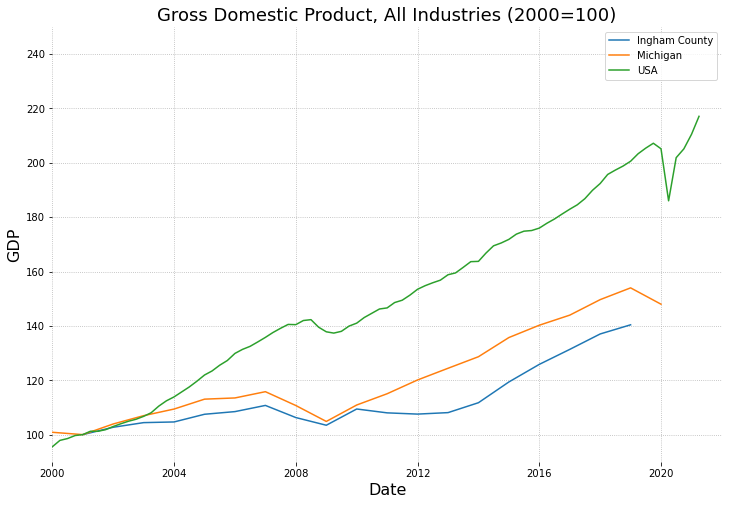

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_gdp["date"], ingham_gdp_norm, label="Ingham County")
ax.plot(michigan_gdp["date"], michigan_gdp_norm, label="Michigan")
ax.plot(us_gdp["date"], us_gdp_norm, label="USA")
ax.set_title("Gross Domestic Product, All Industries (2000=100)", fontsize=18)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("GDP", fontsize=16)
ax.set_xlim("2000-01-01", "2022-01-01")
ax.set_ylim(90, 250)
plt.legend()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":");

## Estimate median household income

In [16]:
dtypes = {"date": "date", "value": "float"}
ingham_med_hh = parse_fred(download_fred("MHIMI26065A052NCEN"), dtypes=dtypes)
usa_med_hh = parse_fred(download_fred("MHIUS00000A052NCEN"), dtypes=dtypes)
michigan_med_hh = parse_fred(download_fred("MHIMI26000A052NCEN"), dtypes=dtypes)

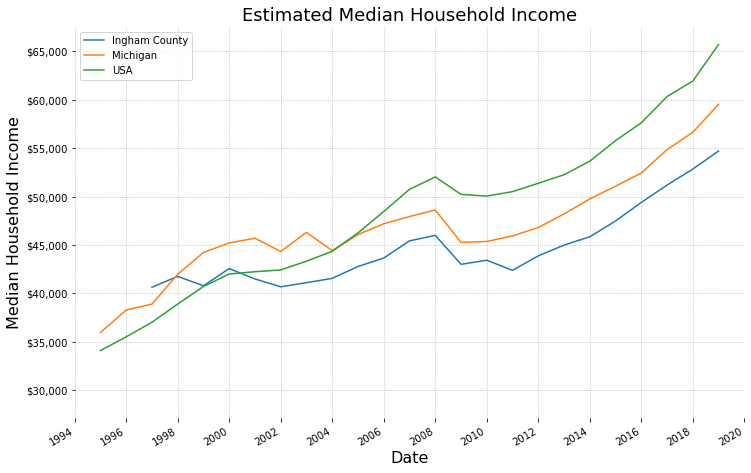

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_med_hh["date"], ingham_med_hh["value"], label="Ingham County")
ax.plot(michigan_med_hh["date"], michigan_med_hh["value"], label="Michigan")
ax.plot(usa_med_hh["date"], usa_med_hh["value"], label="USA")
ax.set_title("Estimated Median Household Income", fontsize=18)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Median Household Income", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("${x:,g}"))
fig.autofmt_xdate()
ax.set_xlim("1994-01-01", "2020-01-01")
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

## Industries

Data from the Quarterly Census of Employment and Wages retrieved from https://milmi.org/DataSearch/QCEW.

In [18]:
ind_full_df = pd.read_csv(
    os.path.join(DATA_FOLDER, "Industry_Full_Data_Michigan.csv"),
)

In [19]:
ind_full_ingham_df = pd.read_csv(
    os.path.join(DATA_FOLDER, "Industry_Full_Data_Ingham.csv"),
)

In [20]:
ind_full_df.shape

(43367, 27)

In [21]:
ind_full_df.head()

,Year (copy),PeriodCode (copy),Area (copy),ID,Area,Year,Period,Industry Code,Industry Code Title,Ownership,...,PeriodCode,Reset Button,State Code,State Name,SubAreaType,# of Establishments,Average Employment,Average Weekly Wages,Month2Employment,Total Wages
0,2015,0,Michigan,334242869,Michigan,2015,Annual,72,Accommodation and Food Services,Federal Government,...,0,Reset Filters,26,Michigan,NaN,2,16,457,NaN,365765
1,2015,0,Michigan,334236281,Michigan,2015,Annual,56,Administrative and Waste Services,Federal Government,...,0,Reset Filters,26,Michigan,NaN,2,5,624,NaN,162344
2,2015,0,Michigan,334241517,Michigan,2015,Annual,71,"Arts, Entertainment, and Recreation",Federal Government,...,0,Reset Filters,26,Michigan,NaN,15,251,901,NaN,11628022
3,2015,0,Michigan,334237709,Michigan,2015,Annual,61,Educational Services,Federal Government,...,0,Reset Filters,26,Michigan,NaN,1,7,1099,NaN,399859
4,2015,0,Michigan,334230371,Michigan,2015,Annual,52,Finance and Insurance,Federal Government,...,0,Reset Filters,26,Michigan,NaN,21,208,1583,NaN,17133020


In [22]:
to_drop = [
    "Year (copy)",
    "PeriodCode (copy)",
    "Area (copy)",
    "ID",
    "Area",
    "Area Type Name",
    "Industry Level",
    "StateSelected",
#     "Month1Employment",
#     "Month2Employment",
#     "Month3Employment",
    "Period Type",
    "Period Type Description",
#     "PeriodCode",
    "Reset Button",
    "State Code",
    "State Name",
    "# of Establishments"
]
ind_filtered = ind_full_df.drop(columns=to_drop)

In [23]:
ind_ingham_filtered = ind_full_ingham_df.drop(columns=to_drop)

In [24]:
ind_filtered.head()

,Year,Period,Industry Code,Industry Code Title,Ownership,Month1Employment,Month3Employment,PeriodCode,SubAreaType,Average Employment,Average Weekly Wages,Month2Employment,Total Wages
0,2015,Annual,72,Accommodation and Food Services,Federal Government,NaN,NaN,0,NaN,16,457,NaN,365765
1,2015,Annual,56,Administrative and Waste Services,Federal Government,NaN,NaN,0,NaN,5,624,NaN,162344
2,2015,Annual,71,"Arts, Entertainment, and Recreation",Federal Government,NaN,NaN,0,NaN,251,901,NaN,11628022
3,2015,Annual,61,Educational Services,Federal Government,NaN,NaN,0,NaN,7,1099,NaN,399859
4,2015,Annual,52,Finance and Insurance,Federal Government,NaN,NaN,0,NaN,208,1583,NaN,17133020


The data is incomplete for 2020, there's only the first three quarters available.

In [25]:
ind_filtered[ind_filtered["Year"]==2020]["Period"].unique()

array(['Annual', '1st Quarter', '2nd Quarter', '3rd Quarter',
       '4th Quarter'], dtype=object)

In [26]:
ind_full_df.dtypes

Year (copy)                  int64
PeriodCode (copy)            int64
Area (copy)                 object
ID                           int64
Area                        object
Year                         int64
Period                      object
Industry Code                int64
Industry Code Title         object
Ownership                   object
Area Type Name              object
Industry Level              object
Period Type Description     object
StateSelected                 bool
Month1Employment           float64
Month3Employment           float64
Period Type                  int64
PeriodCode                   int64
Reset Button                object
State Code                   int64
State Name                  object
SubAreaType                float64
# of Establishments          int64
Average Employment           int64
Average Weekly Wages         int64
Month2Employment           float64
Total Wages                  int64
dtype: object

In [27]:
ind_full_df[ind_full_df["Year"]==2020]

,Year (copy),PeriodCode (copy),Area (copy),ID,Area,Year,Period,Industry Code,Industry Code Title,Ownership,...,PeriodCode,Reset Button,State Code,State Name,SubAreaType,# of Establishments,Average Employment,Average Weekly Wages,Month2Employment,Total Wages
40729,2020,0,Michigan,418113231,Michigan,2020,Annual,0,"Total, All Industries",Federal Government,...,0,Reset Filters,26,Michigan,NaN,1569,54048,1552,NaN,4354829847
40730,2020,0,Michigan,418113233,Michigan,2020,Annual,0,"Total, All Industries",Local Government,...,0,Reset Filters,26,Michigan,NaN,4976,337317,992,NaN,17387642139
40731,2020,0,Michigan,418156677,Michigan,2020,Annual,72,Accommodation and Food Services,Private,...,0,Reset Filters,26,Michigan,NaN,19364,287965,385,NaN,5752982683
40732,2020,0,Michigan,418149596,Michigan,2020,Annual,56,Administrative and Waste Services,Private,...,0,Reset Filters,26,Michigan,NaN,14227,241842,810,NaN,10165414192
40733,2020,0,Michigan,418116141,Michigan,2020,Annual,11,"Agriculture, Forestry, Fishing & Hunting",Private,...,0,Reset Filters,26,Michigan,NaN,3152,30034,717,NaN,1115353618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42818,2020,4,Michigan,418151053,Michigan,2020,4th Quarter,5621,Waste Collection,Private,...,4,Reset Filters,26,Michigan,NaN,317,6056,1277,6103.0,100570926
42819,2020,4,Michigan,418151062,Michigan,2020,4th Quarter,5622,Waste Treatment and Disposal,Private,...,4,Reset Filters,26,Michigan,NaN,176,3088,1368,3047.0,54902229
42820,2020,4,Michigan,418119572,Michigan,2020,4th Quarter,2213,"Water, Sewage and Other Systems",Private,...,4,Reset Filters,26,Michigan,NaN,85,707,1580,726.0,14521230
42821,2020,4,Michigan,418115103,Michigan,2020,4th Quarter,0,"Total, All Industries",Private,...,4,Reset Filters,26,Michigan,NaN,258200,3512506,1264,3534310.0,57719906944


In [28]:
ind_annual_df = ind_full_df[(ind_full_df["Industry Code"] <= 100) & (ind_full_df["Period"]=="Annual")].sort_values("Year")
ind_annual_df.loc[:, "Year"] = pd.to_datetime(ind_annual_df["Year"], format="%Y")

In [29]:
ind_annual_ingham_df = ind_full_ingham_df[(ind_full_ingham_df["Industry Code"] <= 100) & (ind_full_ingham_df["Period"]=="Annual")].sort_values("Year")
ind_annual_ingham_df.loc[:, "Year"] = pd.to_datetime(ind_annual_ingham_df["Year"], format="%Y")

In [30]:
ind_annual_df["Industry Code Title"].unique()

array(['Agriculture, Forestry, Fishing & Hunting', 'Construction',
       'Arts, Entertainment, and Recreation', 'Educational Services',
       'Finance and Insurance', 'Health Care and Social Assistance',
       'Information', 'Management of Companies and Enterprises',
       'Manufacturing', 'Administrative and Waste Services',
       'Professional and Technical Services',
       'Real Estate and Rental and Leasing', 'Retail Trade',
       'Other Services (except Public Administration)', 'Wholesale Trade',
       'Mining', 'Transportation and Warehousing', 'Utilities',
       'Total, All Industries', 'Accommodation and Food Services',
       'Public Administration', 'Unclassified'], dtype=object)

In [31]:
ind_annual_df[["Year", "Industry Code Title", "Average Weekly Wages"]].sort_values(
    by=["Year", "Average Weekly Wages"],
    ascending=False
)

,Year,Industry Code Title,Average Weekly Wages
40749,2020-01-01,Utilities,2503
40740,2020-01-01,Management of Companies and Enterprises,2436
40744,2020-01-01,Professional and Technical Services,1782
40737,2020-01-01,Finance and Insurance,1737
40739,2020-01-01,Information,1707
...,...,...,...
2305,2000-01-01,Other Services (except Public Administration),445
2298,2000-01-01,"Arts, Entertainment, and Recreation",420
2308,2000-01-01,Retail Trade,403
1974,2000-01-01,"Agriculture, Forestry, Fishing & Hunting",360


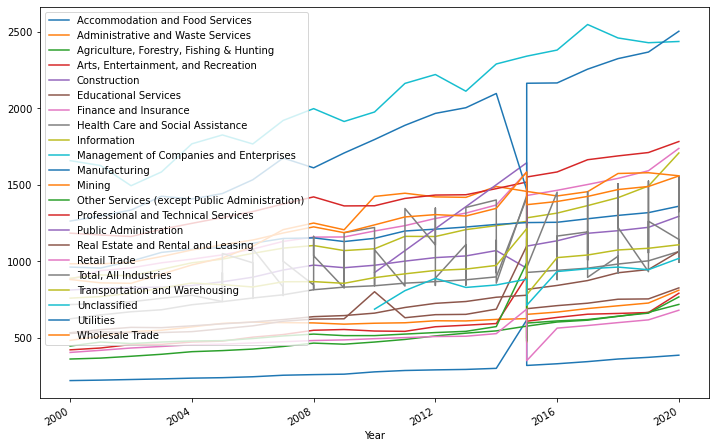

In [32]:
ind_annual_df.sort_values("Year").set_index("Year").groupby("Industry Code Title")["Average Weekly Wages"].plot(
    figsize=(12, 8),
    legend=True,
);

### What are the top industries by wages?

In [33]:
top_wages = ind_annual_df[(ind_annual_df["Year"] >= "2016") & (ind_annual_df["Industry Code Title"] != "Total, All Industries")].groupby("Industry Code Title")["Average Weekly Wages"].median().sort_values(ascending=False)
top_wages

Industry Code Title
Management of Companies and Enterprises          2436
Utilities                                        2324
Professional and Technical Services              1688
Mining                                           1558
Finance and Insurance                            1541
Wholesale Trade                                  1468
Information                                      1415
Manufacturing                                    1299
Construction                                     1199
Transportation and Warehousing                   1073
Health Care and Social Assistance                 981
Unclassified                                      950
Real Estate and Rental and Leasing                924
Educational Services                              751
Administrative and Waste Services                 708
Arts, Entertainment, and Recreation               658
Other Services (except Public Administration)     640
Agriculture, Forestry, Fishing & Hunting          639
Retail T

### What are the top industries by employment?

In [34]:
top_employ = ind_annual_df[(ind_annual_df["Year"] >= "2016") & (ind_annual_df["Industry Code Title"] != "Total, All Industries")].groupby("Industry Code Title")["Average Employment"].median().sort_values(ascending=False)
top_employ

Industry Code Title
Manufacturing                                    615108
Health Care and Social Assistance                590732
Retail Trade                                     469199
Accommodation and Food Services                  378335
Professional and Technical Services              295185
Administrative and Waste Services                286797
Wholesale Trade                                  171442
Construction                                     164115
Finance and Insurance                            148523
Other Services (except Public Administration)    137568
Transportation and Warehousing                   125972
Management of Companies and Enterprises           68417
Educational Services                              63986
Information                                       56247
Real Estate and Rental and Leasing                54180
Arts, Entertainment, and Recreation               52982
Agriculture, Forestry, Fishing & Hunting          30329
Utilities                   

In [35]:
top_employ_names = top_employ.index[:10].tolist()
top_wages_names = top_wages.index[:10].tolist()

In [36]:
colors = tuple(f"C{i}" for i in range(10))
styles = tuple(itertools.product(("solid", "dashed"), colors))

In [37]:
ind_annual_df[(ind_annual_df["Year"]=="2015") & (ind_annual_df["Industry Code Title"]=="Information")]

,Year (copy),PeriodCode (copy),Area (copy),ID,Area,Year,Period,Industry Code,Industry Code Title,Ownership,...,PeriodCode,Reset Button,State Code,State Name,SubAreaType,# of Establishments,Average Employment,Average Weekly Wages,Month2Employment,Total Wages
470,2015,0,Michigan,334227895,Michigan,2015-01-01,Annual,51,Information,Private,...,0,Reset Filters,26,Michigan,NaN,4962,56462,1283,NaN,3766884416
6,2015,0,Michigan,334227893,Michigan,2015-01-01,Annual,51,Information,Federal Government,...,0,Reset Filters,26,Michigan,NaN,2,28,1260,NaN,1862746
73,2015,0,Michigan,334227894,Michigan,2015-01-01,Annual,51,Information,Local Government,...,0,Reset Filters,26,Michigan,NaN,157,4580,470,NaN,111844250


What is the column "ownership"? It is the employer type (government, local, etc).

Some industries have multiple ownership values only for 2015, for example, see the industry "Information".

In [38]:
ind_df_sum = ind_annual_df.groupby(["Year", "Industry Code Title"])["Average Employment"].sum()

In [39]:
ind_df_sum[ind_df_sum.index.isin(["2019"], level=0)]

Year        Industry Code Title                          
2019-01-01  Accommodation and Food Services                   380806
            Administrative and Waste Services                 285188
            Agriculture, Forestry, Fishing & Hunting           30081
            Arts, Entertainment, and Recreation                53493
            Construction                                      173015
            Educational Services                               63804
            Finance and Insurance                             152835
            Health Care and Social Assistance                 597379
            Information                                        55298
            Management of Companies and Enterprises            70463
            Manufacturing                                     625769
            Mining                                              5541
            Other Services (except Public Administration)     140351
            Professional and Technical Servic

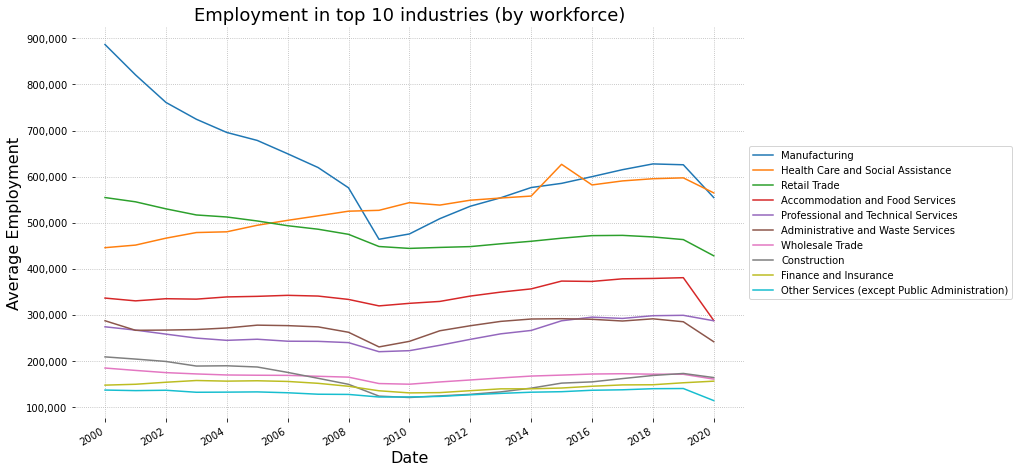

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
i = 0  # this index allows us to have line type combining color and style
for name in top_employ_names:
    ax.plot(
        ind_df_sum[ind_df_sum.index.isin([name], level=1)].index.get_level_values(0),
        ind_df_sum[ind_df_sum.index.isin([name], level=1)],
        color=styles[i][1],
        linestyle=styles[i][0],
        label=name,
    )
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
    i += 1
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Average Employment", fontsize=16)
ax.set_title("Employment in top 10 industries (by workforce)", fontsize=18)
fig.autofmt_xdate()
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left');

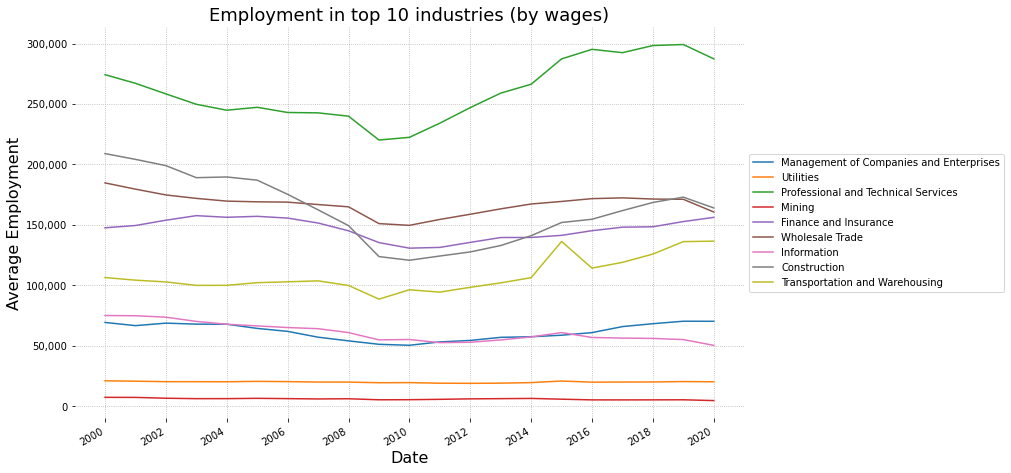

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
i = 0
for name in top_wages_names:
    if name == "Manufacturing":
        continue
    ax.plot(
        ind_df_sum[ind_df_sum.index.isin([name], level=1)].index.get_level_values(0),
        ind_df_sum[ind_df_sum.index.isin([name], level=1)],
        color=styles[i][1],
        linestyle=styles[i][0],
        label=name,
    )
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
    i += 1
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Average Employment", fontsize=16)
ax.set_title("Employment in top 10 industries (by wages)", fontsize=18)
fig.autofmt_xdate()
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left');

## How employment is changing depending on industry?

We plot the change in employment between 2016 and 2019, sorted by industry from highest wages to lowest wages.

In [42]:
for name in top_wages.index.tolist():
    employment_2019 = ind_annual_df[(ind_annual_df["Year"]=="2019") & (ind_annual_df["Industry Code Title"]==name)]["Average Employment"].values[0]
    employment_2016 = ind_annual_df[(ind_annual_df["Year"]=="2016") & (ind_annual_df["Industry Code Title"]==name)]["Average Employment"].values[0]
    print(name, f"{(employment_2019-employment_2016)/employment_2016*100:+.2f}%")

Management of Companies and Enterprises +15.40%
Utilities +2.45%
Professional and Technical Services +1.35%
Mining +1.67%
Finance and Insurance +5.19%
Wholesale Trade -0.32%
Information -3.07%
Manufacturing +4.30%
Construction +11.80%
Transportation and Warehousing +19.14%
Health Care and Social Assistance +2.64%
Unclassified +34.24%
Real Estate and Rental and Leasing +6.62%
Educational Services -2.08%
Administrative and Waste Services -1.85%
Arts, Entertainment, and Recreation +3.68%
Other Services (except Public Administration) +2.77%
Agriculture, Forestry, Fishing & Hunting -3.52%
Retail Trade -1.83%
Accommodation and Food Services +2.18%


## What's the average wage?

In [43]:
industry_names = top_wages.index.tolist()

In [44]:
total_wages_2019 = 0
total_employ_2019 = 0
for name in industry_names:
    employ = ind_annual_df[(ind_annual_df["Year"]=="2019")&(ind_annual_df["Industry Code Title"]==name)]["Average Employment"].values[0]
    wages = ind_annual_df[(ind_annual_df["Year"]=="2019")&(ind_annual_df["Industry Code Title"]==name)]["Average Weekly Wages"].values[0]
    total_wages_2019 += employ * wages
    total_employ_2019 += ind_annual_df[(ind_annual_df["Year"]=="2019")&(ind_annual_df["Industry Code Title"]==name)]["Average Employment"].values[0]

In [45]:
# average wages in 2019 across all industries
total_wages_2019 / total_employ_2019

1053.7779312782675

In 2019 the average wages across industries correspond approximately to the average wages in transport and warehousing.

In [46]:
for name in industry_names:
    print(name, ind_annual_df[(ind_annual_df["Year"]=="2019") & (ind_annual_df["Industry Code Title"]==name)]["Average Weekly Wages"].values[0])

Management of Companies and Enterprises 2428
Utilities 2367
Professional and Technical Services 1710
Mining 1578
Finance and Insurance 1591
Wholesale Trade 1488
Information 1491
Manufacturing 1317
Construction 1221
Transportation and Warehousing 1084
Health Care and Social Assistance 1002
Unclassified 944
Real Estate and Rental and Leasing 945
Educational Services 753
Administrative and Waste Services 726
Arts, Entertainment, and Recreation 664
Other Services (except Public Administration) 660
Agriculture, Forestry, Fishing & Hunting 665
Retail Trade 616
Accommodation and Food Services 371


In [47]:
for year in ("2015", "2016", "2017", "2018", "2019"):
    total_wages = ind_annual_df[(ind_annual_df["Industry Code Title"]=="Total, All Industries") & (ind_annual_df["Year"]==year)]["Total Wages"].sum()
    total_employ = ind_annual_df[(ind_annual_df["Industry Code Title"]=="Total, All Industries") & (ind_annual_df["Year"]==year)]["Average Employment"].sum()
    print(f"Average annual wages ({year}): ${total_wages / total_employ:,.0f}")

Average annual wages (2015): $50,047
Average annual wages (2016): $50,952
Average annual wages (2017): $52,488
Average annual wages (2018): $53,844
Average annual wages (2019): $54,956


In [48]:
wages_increase_pct = (54956-50047)/50047
print(f"Wages increase between 2015 and 2019: {wages_increase_pct*100:.2f}%")

Wages increase between 2015 and 2019: 9.81%


We calculate the inflation between December 2015 and December 2019. Data is from https://www.bls.gov/cpi/data.htm and https://download.bls.gov/pub/time.series/cu/.

In [49]:
cpi_12_2015 = 237.761
cpi_12_2019 = 258.203
cpi_increase_pct = (cpi_12_2019-cpi_12_2015)/cpi_12_2015
print(f"CPI increase between 2015 and 2019: {cpi_increase_pct*100:.2f}%")

CPI increase between 2015 and 2019: 8.60%


## Job Growth

In [50]:
job_growth_df = ind_filtered[(ind_filtered["PeriodCode"]!=0) & (ind_filtered["Industry Code Title"]=="Total, All Industries")][["Year", "PeriodCode", "Month1Employment", "Month2Employment", "Month3Employment", "Ownership"]]
job_growth_df

,Year,PeriodCode,Month1Employment,Month2Employment,Month3Employment,Ownership
4750,2015,1,50895.0,51027.0,51076.0,Federal Government
4751,2015,1,349467.0,355640.0,357658.0,Local Government
5159,2015,1,3497577.0,3501159.0,3518594.0,Private
5160,2015,1,148802.0,151795.0,151979.0,State Government
5161,2015,2,51640.0,51106.0,51317.0,Federal Government
...,...,...,...,...,...,...
42407,2020,3,137459.0,142783.0,149259.0,State Government
42408,2020,4,55746.0,52332.0,52891.0,Federal Government
42409,2020,4,341014.0,345820.0,336327.0,Local Government
42821,2020,4,3542516.0,3534310.0,3460693.0,Private


In [51]:
job_growth_ingham = ind_ingham_filtered[(ind_ingham_filtered["PeriodCode"]!=0) & (ind_ingham_filtered["Industry Code Title"]=="Total, All Industries")][["Year", "PeriodCode", "Month1Employment", "Month2Employment", "Month3Employment", "Ownership"]]
job_growth_ingham

,Year,PeriodCode,Month1Employment,Month2Employment,Month3Employment,Ownership
156,2015,1,1476.0,1483.0,1478.0,Federal Government
157,2015,1,13106.0,13292.0,13305.0,Local Government
246,2015,1,102028.0,103012.0,103058.0,Private
247,2015,1,27168.0,27140.0,27125.0,State Government
248,2015,2,1508.0,1469.0,1458.0,Federal Government
...,...,...,...,...,...,...
9504,2017,4,110098.0,110382.0,109966.0,Private
9505,2017,1,28285.0,28505.0,28457.0,State Government
9506,2017,2,28506.0,29071.0,28010.0,State Government
9507,2017,3,28484.0,29413.0,29536.0,State Government


In [52]:
melted = pd.melt(job_growth_df, id_vars=["Year", "PeriodCode", "Ownership"], value_vars=["Month1Employment", "Month2Employment", "Month3Employment"])
sort = melted.sort_values(by=["Year", "PeriodCode", "variable"])

In [53]:
melted_ingham = pd.melt(job_growth_ingham, id_vars=["Year", "PeriodCode", "Ownership"], value_vars=["Month1Employment", "Month2Employment", "Month3Employment"])
sort_ingham = melted_ingham.sort_values(by=["Year", "PeriodCode", "variable"])

In [54]:
def add_date(row):
    year = row["Year"]
    month_in_quarter = int(row["variable"][5])
    month = (row["PeriodCode"] - 1)*3 + month_in_quarter
    return pd.to_datetime(f"{year}-{month}")

In [55]:
sort["date"] = sort.apply(add_date, axis=1)

In [56]:
sort_ingham["date"] = sort_ingham.apply(add_date, axis=1)

In [57]:
sort.head(12)

,Year,PeriodCode,Ownership,variable,value,date
226,2000,1,Private,Month1Employment,3828333.0,2000-01-01
496,2000,1,Private,Month2Employment,3827576.0,2000-02-01
766,2000,1,Private,Month3Employment,3859169.0,2000-03-01
227,2000,2,Private,Month1Employment,3913181.0,2000-04-01
497,2000,2,Private,Month2Employment,3973722.0,2000-05-01
767,2000,2,Private,Month3Employment,4020075.0,2000-06-01
228,2000,3,Private,Month1Employment,3963489.0,2000-07-01
498,2000,3,Private,Month2Employment,3999752.0,2000-08-01
768,2000,3,Private,Month3Employment,3968345.0,2000-09-01
229,2000,4,Private,Month1Employment,3953248.0,2000-10-01


From 2006 onward, data is divided by "Ownership" that includes "Private", "Federal Government", "State Government", and "Local Government". Before 2005 data is mostly for "Private".

In [58]:
sort[sort["Year"].isin([2006])]

,Year,PeriodCode,Ownership,variable,value,date
132,2006,1,Federal Government,Month1Employment,54068.0,2006-01-01
136,2006,1,Local Government,Month1Employment,437569.0,2006-01-01
140,2006,1,Private,Month1Employment,3528970.0,2006-01-01
144,2006,1,State Government,Month1Employment,137431.0,2006-01-01
402,2006,1,Federal Government,Month2Employment,53927.0,2006-02-01
406,2006,1,Local Government,Month2Employment,450981.0,2006-02-01
410,2006,1,Private,Month2Employment,3515642.0,2006-02-01
414,2006,1,State Government,Month2Employment,139168.0,2006-02-01
672,2006,1,Federal Government,Month3Employment,53853.0,2006-03-01
676,2006,1,Local Government,Month3Employment,454854.0,2006-03-01


In [59]:
sort_recent = sort[sort["Year"]>=2006]
sort_recent

,Year,PeriodCode,Ownership,variable,value,date
132,2006,1,Federal Government,Month1Employment,54068.0,2006-01-01
136,2006,1,Local Government,Month1Employment,437569.0,2006-01-01
140,2006,1,Private,Month1Employment,3528970.0,2006-01-01
144,2006,1,State Government,Month1Employment,137431.0,2006-01-01
402,2006,1,Federal Government,Month2Employment,53927.0,2006-02-01
...,...,...,...,...,...,...
539,2020,4,State Government,Month2Employment,149848.0,2020-11-01
806,2020,4,Federal Government,Month3Employment,52891.0,2020-12-01
807,2020,4,Local Government,Month3Employment,336327.0,2020-12-01
808,2020,4,Private,Month3Employment,3460693.0,2020-12-01


In [60]:
sort_recent_ingham = sort_ingham[sort_ingham["Year"]>=2006]

In [61]:
employ_time_series = sort_recent.groupby("date")["value"].sum()

In [62]:
employ_time_series_ingham = sort_recent_ingham.groupby("date")["value"].sum()

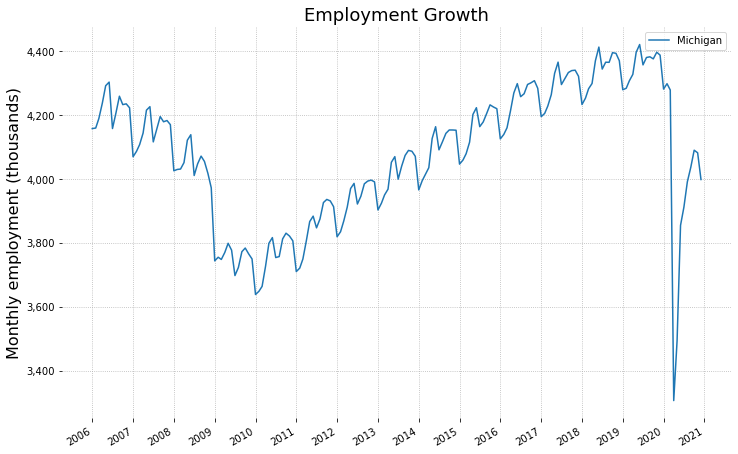

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(employ_time_series.index, employ_time_series/1000, label="Michigan")
ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
# ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Monthly employment (thousands)", fontsize=16)
ax.set_title("Employment Growth", fontsize=18)
fig.autofmt_xdate()
plt.legend();

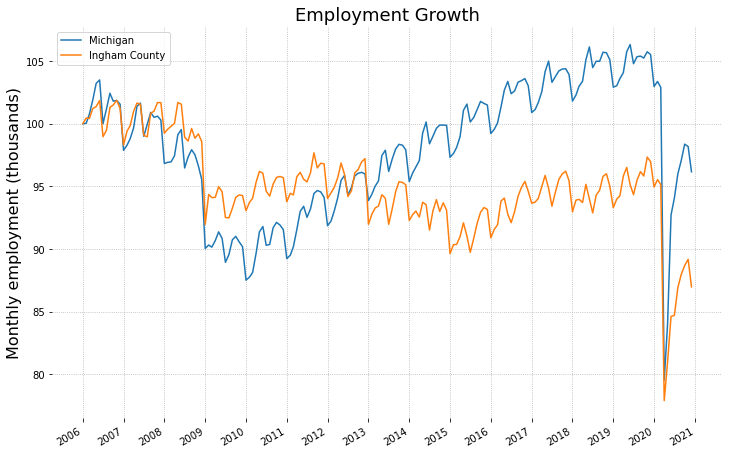

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(employ_time_series.index, employ_time_series/employ_time_series.iloc[0]*100, label="Michigan")
ax.plot(employ_time_series_ingham.index, employ_time_series_ingham/employ_time_series_ingham.iloc[0]*100, label="Ingham County")
ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
# ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Monthly employment (thousands)", fontsize=16)
ax.set_title("Employment Growth", fontsize=18)
fig.autofmt_xdate()
plt.legend();

## Job recovery post-pandemic

Michigan and Ingham county recovered their jobs in 2020 (compared to 2019 levels), to similar levels.

In [65]:
mich_2019_09 = employ_time_series.loc["2019-09"]
mich_2020_09 = employ_time_series.loc["2020-09"]
recov = mich_2020_09.values / mich_2019_09.values
recov[0]

0.9212192112269326

In [66]:
ing_2019_09 = employ_time_series_ingham.loc["2019-09"]
ing_2020_09 = employ_time_series_ingham.loc["2020-09"]
recov = ing_2020_09.values / ing_2019_09.values
recov[0]

0.9148361086084302

## Job diversity

In [67]:
ind_2019 = ind_annual_df[(ind_annual_df["Year"]=="2019-01-01") & (ind_annual_df["Industry Code Title"]!="Total, All Industries")]

In [68]:
ind_titles = ind_2019["Industry Code Title"].reset_index(drop=True)

In [69]:
employ = ind_2019["Average Employment"].reset_index(drop=True)
employ_sum = employ.cumsum()

In [70]:
category_colors = plt.get_cmap('gist_rainbow')(np.linspace(0, 1, len(ind_titles)))

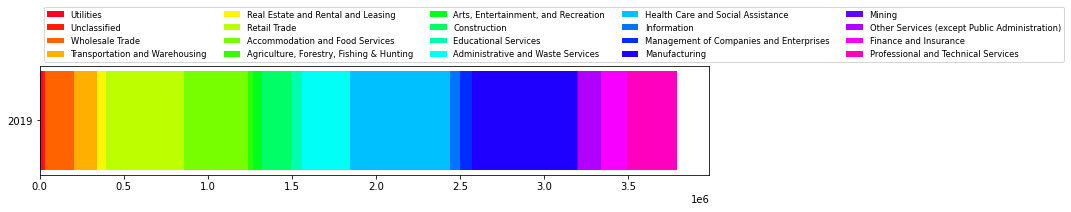

In [73]:
fig, ax = plt.subplots(figsize=(12, 2))

for i, (colname, color) in enumerate(zip(ind_titles, category_colors)):
    widths = employ[i]
    starts = employ_sum[i] - widths
    rects = ax.barh("2019", widths, left=starts, height=0.5,
                    label=colname, color=color)
    
ax.legend(ncol=5, bbox_to_anchor=(0, 1), loc='lower left', fontsize='small');